In [ ]:
!nvidia-smi

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

import os
import torch

BASE_PATH = os.path.dirname(os.getcwd())

VISIBLE_GPUS = [0]


os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
print("CUDA GPUS NUMBER: ", torch.cuda.device_count())


In [ ]:
from IPython import get_ipython


try:
    import detectron2
    print("Detectron2 already installed")
    os.chdir(BASE_PATH)
except ModuleNotFoundError:
    !pip install 'git+https://github.com/facebookresearch/detectron2.git'
    if get_ipython():
        get_ipython().kernel.do_shutdown(restart=True)

Detectron2 already installed


In [ ]:
import torch
torch.cuda.empty_cache()
print(f'Device Name: {torch.cuda.get_device_name()}')
print(f'Device Available: {torch.cuda.is_available()}')
print(f'Device Count: {torch.cuda.device_count()}')

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [ ]:
TRAIN_DATASET_IMG = "/dataset/train/images"
TEST_DATASET_IMG = "/dataset/test/images"
VAL_DATASET_IMG = "/dataset/val/images"

TRAIN_DATASET_JSON = "/dataset/coco_format/train_unified.json"
TEST_DATASET_JSON = "/dataset/coco_format/test_unified.json"
VAL_DATASET_JSON = "/dataset/coco_format/val_unified.json"

train_dataset_name = 'unified_train'
test_dataset_name = 'unified_test'
val_dataset_name = 'unified_val'

DatasetCatalog.clear()
MetadataCatalog.clear()
register_coco_instances(train_dataset_name, {}, TRAIN_DATASET_JSON, TRAIN_DATASET_IMG)
register_coco_instances(test_dataset_name, {}, TEST_DATASET_JSON, TEST_DATASET_IMG)
register_coco_instances(val_dataset_name, {}, VAL_DATASET_JSON, VAL_DATASET_IMG)

In [ ]:
from tabulate import tabulate
from IPython.display import HTML, display
import json

def load_json(json_file_path):
    try:
        with open(json_file_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading JSON {json_file_path}: {e}")
        return None

def datasets_to_table_simplified_with_totals(json_paths):
    summary_data = {}
    coco_keys = ['images', 'annotations', 'categories']
    total_annotations = {"Train": 0, "Validation": 0, "Test": 0}
    total_images = {"Train": 0, "Validation": 0, "Test": 0}

    for dataset_type, json_path in json_paths.items():
        data = load_json(json_path)
        if not data:
            continue

        if not all(key in data for key in coco_keys):
            print(f"Missing key in JSON {json_path}. \nExpected keys: {coco_keys}")
            continue

        for category in data['categories']:
            category_name = category.get('name', 'N/A')

            category_annotations = [
                ann for ann in data['annotations'] if ann.get('category_id') == category.get('id', 'N/A')
            ]
            num_annotations = len(category_annotations)

            image_ids = {ann['image_id'] for ann in category_annotations}
            num_images = len(image_ids)

            total_annotations[dataset_type] += num_annotations
            total_images[dataset_type] += num_images

            if category_name not in summary_data:
                summary_data[category_name] = {"Train": [0, 0], "Validation": [0, 0], "Test": [0, 0]}
            summary_data[category_name][dataset_type] = [num_annotations, num_images]

    sorted_data = sorted(summary_data.items(), key=lambda x: x[0])

    table_data = []
    for category_name, stats in sorted_data:
        row = [
            category_name,
            f"{stats['Train'][0]} ({stats['Train'][0] / total_annotations['Train'] * 100:.1f}%)",
            f"{stats['Train'][1]} ({stats['Train'][1] / total_images['Train'] * 100:.1f}%)",
            f"{stats['Validation'][0]} ({stats['Validation'][0] / total_annotations['Validation'] * 100:.1f}%)",
            f"{stats['Validation'][1]} ({stats['Validation'][1] / total_images['Validation'] * 100:.1f}%)",
            f"{stats['Test'][0]} ({stats['Test'][0] / total_annotations['Test'] * 100:.1f}%)",
            f"{stats['Test'][1]} ({stats['Test'][1] / total_images['Test'] * 100:.1f}%)"
        ]
        table_data.append(row)

    table_data.append([
        "Total",
        f"{total_annotations['Train']} (100.0%)",
        f"{total_images['Train']} (100.0%)",
        f"{total_annotations['Validation']} (100.0%)",
        f"{total_images['Validation']} (100.0%)",
        f"{total_annotations['Test']} (100.0%)",
        f"{total_images['Test']} (100.0%)"
    ])

    headers = [
        "Category Name",
        "Train\nAnnotations", "Train\nImages",
        "Validation\nAnnotations", "Validation\nImages",
        "Test\nAnnotations", "Test\nImages"
    ]

    table_html = tabulate(table_data, headers=headers, tablefmt="html")
    styled_html = f"""
    <div style="overflow-x: auto; width:100%">
        {table_html}
    </div>
    """
    display(HTML(styled_html))

json_paths = {
    "Train": TRAIN_DATASET_JSON,
    "Validation": VAL_DATASET_JSON,
    "Test": TEST_DATASET_JSON
}

datasets_to_table_simplified_with_totals(json_paths)

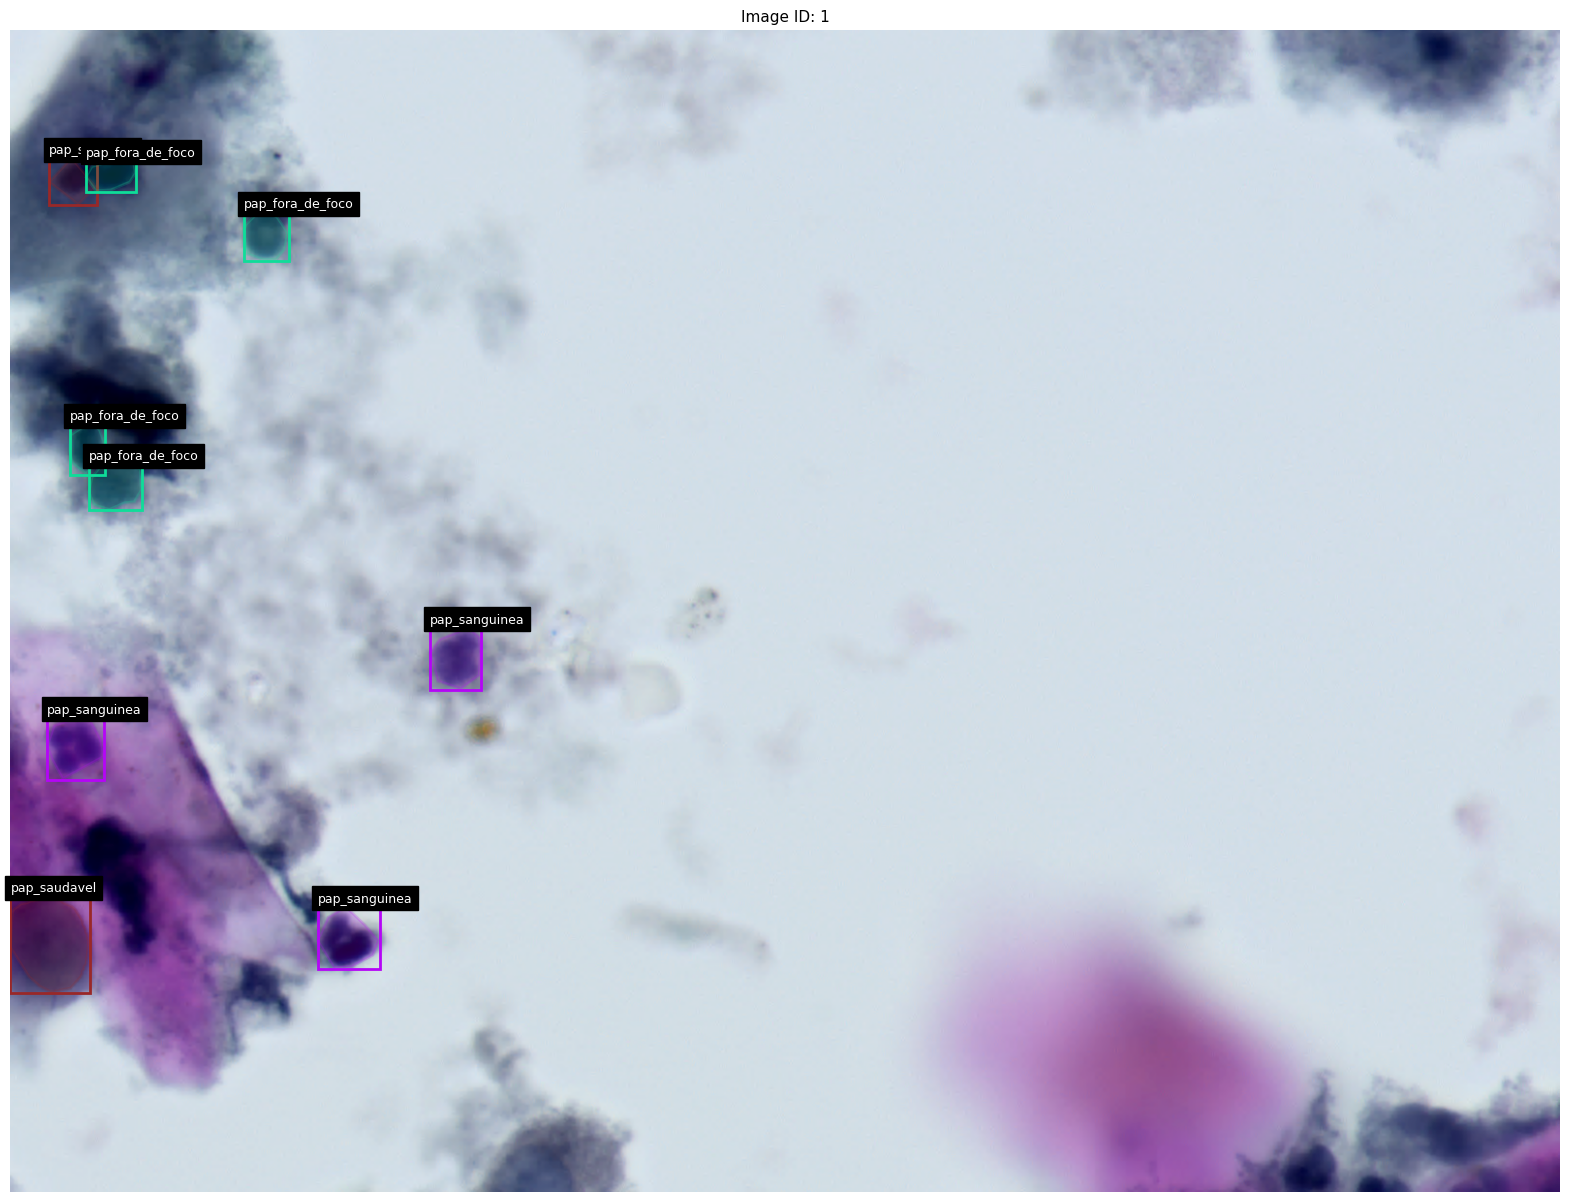

In [14]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from PIL import Image

def load_json(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    return data

def count_categories(data):
    categories = data['categories']
    category_id_to_name = {cat['id']: cat['name'] for cat in categories}
    return category_id_to_name

def attach_color_to_each_category(category_id_to_name):
    np.random.seed(42)
    category_id_to_color = {}
    for cat_id in category_id_to_name:
        color = tuple(np.random.rand(3,))
        category_id_to_color[cat_id] = color
    return category_id_to_color

def plot_bounding_box(ax, bbox, edgecolor):
    x, y, width, height = bbox
    rect = Rectangle((x, y), width, height, linewidth=2, edgecolor=edgecolor, facecolor='none')
    ax.add_patch(rect)

def plot_mask_overlay(ax, segmentation, facecolor, edgecolor, alpha):
    for seg in segmentation:
        poly = np.array(seg).reshape((int(len(seg)/2), 2))
        polygon = Polygon(poly, facecolor=facecolor, edgecolor=edgecolor, linewidth=2, alpha=alpha)
        ax.add_patch(polygon)

def plot_image_overlayed(images_path, json_file_path, max_images=5, plot_contours=True, plot_masks=True, figure_size=(20, 20), legend_font_size=12, alpha=0.2):
    if alpha > 1:
        alpha = 0.2
    data = load_json(json_file_path)
    images = {img['id']: img for img in data['images']}
    annotations = data['annotations']
    category_id_to_name = count_categories(data)
    category_id_to_color = attach_color_to_each_category(category_id_to_name)
    image_id_to_annotations = {}
    for ann in annotations:
        image_id = ann['image_id']
        if image_id not in image_id_to_annotations:
            image_id_to_annotations[image_id] = []
        image_id_to_annotations[image_id].append(ann)
    count = 0
    for image_id, image_info in images.items():
        file_name = image_info['file_name']
        image_path = os.path.join(images_path, file_name)
        if not os.path.exists(image_path):
            continue
        img = Image.open(image_path).convert('RGB')
        plt.figure(figsize=figure_size)
        plt.imshow(img)
        ax = plt.gca()
        anns = image_id_to_annotations.get(image_id, [])
        for ann in anns:
            cat_id = ann['category_id']
            color = category_id_to_color.get(cat_id, (1, 0, 0))
            category_name = category_id_to_name.get(cat_id, 'N/A')
            if plot_masks and 'segmentation' in ann and isinstance(ann['segmentation'], list):
                facecolor = (*color, 0.5)  # Convert to RGBA
                plot_mask_overlay(ax, ann['segmentation'], facecolor=facecolor, edgecolor=color, alpha=alpha)
            if plot_contours and 'bbox' in ann:
                plot_bounding_box(ax, ann['bbox'], edgecolor=color)
            if 'bbox' in ann:
                bbox = ann['bbox']
                x, y = bbox[0], bbox[1]
                ax.text(x, y - 5, category_name, color='white', fontsize=legend_font_size, backgroundcolor='black')
        plt.axis('off')
        plt.title(f"Image ID: {image_id}", fontsize=legend_font_size + 2)
        plt.show()
        count += 1
        if count >= max_images:
            break

plot_image_overlayed(
    TRAIN_DATASET_IMG, 
    TRAIN_DATASET_JSON, 
    max_images=1, 
    plot_contours=True,
    plot_masks=True,
    figure_size=(20, 20), 
    legend_font_size=9,
    alpha=0.2
)


dict_keys(['validation_loss_rpn_loc', 'rpn/num_neg_anchors', 'roi_head/num_bg_samples', 'total_loss', 'loss_box_reg', 'mask_rcnn/accuracy', 'fast_rcnn/cls_accuracy', 'validation_loss_rpn_cls', 'validation_loss_cls', 'eta_seconds', 'loss_rpn_cls', 'fast_rcnn/false_negative', 'mask_rcnn/false_positive', 'iteration', 'loss_mask', 'rpn/num_pos_anchors', 'roi_head/num_fg_samples', 'loss_cls', 'time', 'validation_loss_box_reg', 'validation_loss_mask', 'loss_rpn_loc', 'validation_total_loss', 'mask_rcnn/false_negative', 'data_time', 'rank_data_time', 'fast_rcnn/fg_cls_accuracy', 'lr'])


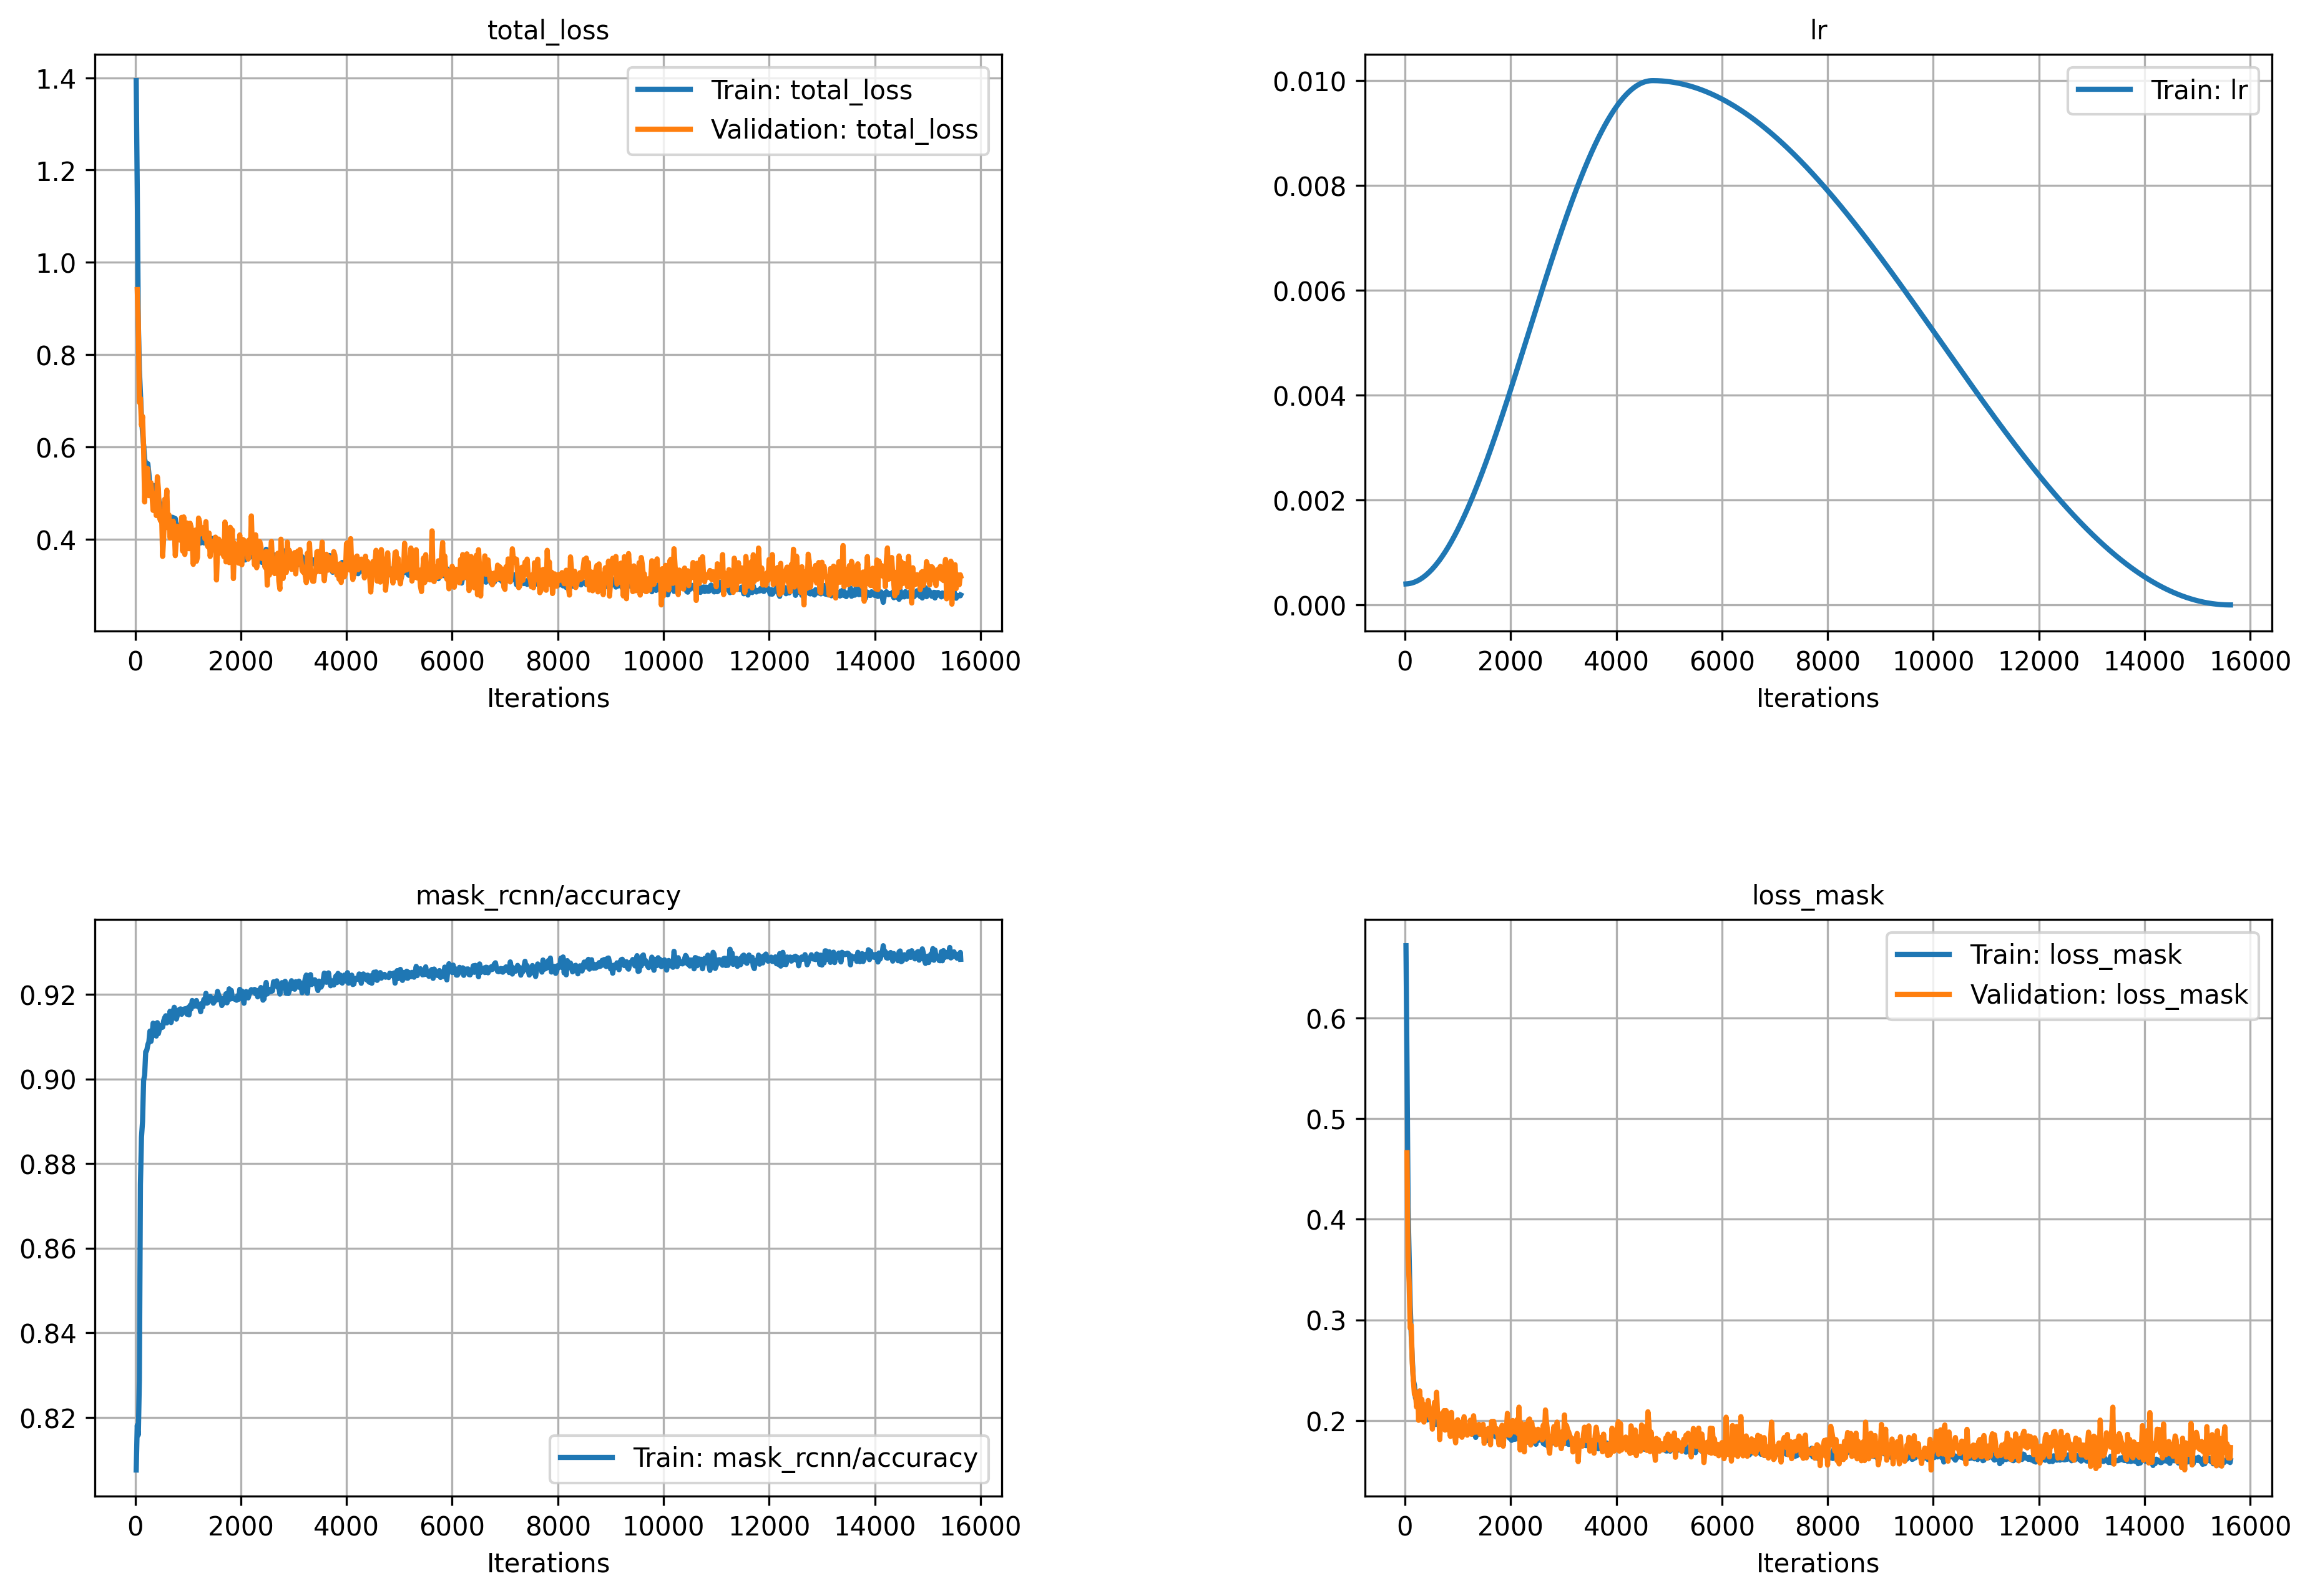

In [ ]:
import os
import json
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def process_metrics(metric_file):
    torch.cuda.empty_cache()
    metrics = []
    with open(metric_file, 'r') as infile:
        for line in infile:
            metrics.append(json.loads(line))

    APmetrics = metrics[-1] if "bbox/AP" in metrics[-1].keys() else None
    if APmetrics is not None:
        metrics.pop(-1)
        APmetrics.pop('iteration', None)

    all_keys = set()
    for m in metrics:
        all_keys.update(m.keys())

    mt = dict()
    for k in all_keys:
        _temp = [m.get(k, None) for m in metrics]
        mt[k] = _temp

    return mt, APmetrics

def plot_training_and_validation(mt, keys, validation_prefix="validation_", figsize=(15, 10), rem_background=True):
    if rem_background:
        import matplotlib as mpl
        mpl.rcParams['figure.facecolor'] = 'none'
        mpl.rcParams['axes.facecolor'] = 'none'
    
    print(mt.keys())
    
    fig = plt.figure(figsize=figsize, dpi=300)
    fig.subplots_adjust(hspace=0.5, wspace=0.4)
    
    num_plots = len(keys)
    rows = 2
    cols = (num_plots // rows) + (1 if num_plots % rows != 0 else 0)
    
    for i, k in enumerate(keys):
        if k in mt and 'iteration' in mt:
            plt.subplot(rows, cols, i + 1)
            
            plt.plot(mt["iteration"], mt[k], label=f"Train: {k}", linewidth=2.0)
            
            val_key = validation_prefix + k
            if val_key in mt:
                plt.plot(mt["iteration"], mt[val_key], label=f"Validation: {k}", linestyle='-', linewidth=2.0)
            
            plt.xlabel("Iterations", fontsize=10)
            plt.title(k, fontsize=10)
            plt.legend()
            plt.grid()
    
    plt.show()


train_metrics_file = '/projects/maskrcnn/metrics.json'
mt, APmetrics = process_metrics(train_metrics_file)
keys = ["total_loss", "lr", "mask_rcnn/accuracy", "loss_mask"]
plot_training_and_validation(mt, keys, rem_background=False)

###  Inferencing Validation Set

In [18]:
from detectron2.config import CfgNode
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.config import get_cfg, CfgNode
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode, GenericMask, random_color

from detectron2.data import (
    MetadataCatalog,
    DatasetCatalog,
)
import torch
import os
import cv2
import random
import warnings
import math
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [19]:
import os
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader

### Inference on validation set

In [ ]:
def add_onecycle_config(cfg_test):
    cfg_test.ONECYCLE = CfgNode()
    cfg_test.ONECYCLE.LIMIT = 0.01
    cfg_test.ONECYCLE.MAX_MOMENTUM = 0.95
    cfg_test.ONECYCLE.MIN_MOMENTUM = 0.85
    cfg_test.ONECYCLE.THREE_PHASE = False


def inference_on_test_set(test_dataset_name, test_dataset_json, test_dataset_img, weights_path, config_file, output_dir, output_folder_name):
    DatasetCatalog.clear()
    MetadataCatalog.clear()

    register_coco_instances(test_dataset_name, {}, test_dataset_json, test_dataset_img)

    cfg_test = get_cfg()
    add_onecycle_config(cfg_test)
    cfg_test.merge_from_file(config_file)
    cfg_test.MODEL.WEIGHTS = weights_path
    cfg_test.OUTPUT_DIR = output_dir
    os.makedirs(cfg_test.OUTPUT_DIR, exist_ok=True)

    cfg_test.DATASETS.TEST = (test_dataset_name,)

    with torch.no_grad():
    
        predictor = DefaultPredictor(cfg_test)
    
        out_folder = os.path.join(cfg_test.OUTPUT_DIR, output_folder_name)
        os.makedirs(out_folder, exist_ok=True)
    
        evaluator = COCOEvaluator(test_dataset_name, output_dir=out_folder)
        test_loader = build_detection_test_loader(cfg_test, test_dataset_name)
    
        results = inference_on_dataset(predictor.model, test_loader, evaluator)
    
    return results
    

OUTDIR = '/model_weights/mask_rcnn/'



val_results = inference_on_test_set(
    test_dataset_name=val_dataset_name,
    test_dataset_json=VAL_DATASET_JSON,
    test_dataset_img=VAL_DATASET_IMG,
    weights_path=os.path.join(OUTDIR, 'best.pth'),
    config_file=os.path.join(OUTDIR, 'mask_rcnn_R_50_FPN_1x.yaml'),
    output_dir=OUTDIR,
    output_folder_name = 'val'
)

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.352
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.

In [ ]:
from tabulate import tabulate
def evaluation_results_to_table_compact(results):
    if not isinstance(results, dict):
        raise TypeError("The provided results are not in the expected format (dict).")

    categories = set(
        category for metrics in results.values() for category in metrics.keys()
    )
    categories = sorted(categories)

    table_data = []
    for category in categories:
        row = [category]
        for metric_type in results.keys():
            value = results[metric_type].get(category, "N/A")
            row.append(value)
        table_data.append(row)

    headers = ["Category"] + list(results.keys())
    html_table = tabulate(table_data, headers=headers, tablefmt="html")

    datatables_script = """
    <link rel="stylesheet" href="https://cdn.datatables.net/1.13.4/css/jquery.dataTables.min.css">
    <script src="https://code.jquery.com/jquery-3.6.0.min.js"></script>
    <script src="https://cdn.datatables.net/1.13.4/js/jquery.dataTables.min.js"></script>
    <script>
        $(document).ready(function() {
            $('table').DataTable({
                "paging": true,
                "searching": true,
                "ordering": true,
                "info": true,
                "autoWidth": false
            });
        });
    </script>
    <style>
        table.dataTable thead th {
            background-color: #008080;
            color: white;
        }
        div.dataTables_wrapper {
            margin: 20px 0;
        }
    </style>
    """

    styled_html = f"""
    <div style="overflow-x: auto; width:100%">
        {html_table}
    </div>
    {datatables_script}
    """
    display(HTML(styled_html))


evaluation_results_to_table_compact(val_results)

###  Inference on test set

In [23]:
from detectron2.config import CfgNode
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.config import get_cfg, CfgNode
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode, GenericMask, random_color

from detectron2.data import (
    MetadataCatalog,
    DatasetCatalog,
)
import torch
import os
import cv2
import random
import warnings
import math
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
def add_onecycle_config(cfg_test):
    cfg_test.ONECYCLE = CfgNode()
    cfg_test.ONECYCLE.LIMIT = 0.01
    cfg_test.ONECYCLE.MAX_MOMENTUM = 0.95
    cfg_test.ONECYCLE.MIN_MOMENTUM = 0.85
    cfg_test.ONECYCLE.THREE_PHASE = False


def inference_on_test_set(test_dataset_name, test_dataset_json, test_dataset_img, weights_path, config_file, output_dir, output_folder_name):
    DatasetCatalog.clear()
    MetadataCatalog.clear()

    register_coco_instances(test_dataset_name, {}, test_dataset_json, test_dataset_img)

    cfg_test = get_cfg()
    add_onecycle_config(cfg_test)
    cfg_test.merge_from_file(config_file)
    cfg_test.MODEL.WEIGHTS = weights_path
    cfg_test.OUTPUT_DIR = output_dir
    os.makedirs(cfg_test.OUTPUT_DIR, exist_ok=True)

    cfg_test.DATASETS.TEST = (test_dataset_name,)

    with torch.no_grad():
    
        predictor = DefaultPredictor(cfg_test)
    
        out_folder = os.path.join(cfg_test.OUTPUT_DIR, output_folder_name)
        os.makedirs(out_folder, exist_ok=True)
    
        evaluator = COCOEvaluator(test_dataset_name, output_dir=out_folder)
        test_loader = build_detection_test_loader(cfg_test, test_dataset_name)
    
        results = inference_on_dataset(predictor.model, test_loader, evaluator)
    
    return results



OUTDIR = '/results/mask_rcnn/'


test_results = inference_on_test_set(
    test_dataset_name=test_dataset_name,
    test_dataset_json=TEST_DATASET_JSON,
    test_dataset_img=TEST_DATASET_IMG,
    weights_path=os.path.join(OUTDIR, 'best.pth'),
    config_file=os.path.join(OUTDIR, 'mask_rcnn_R_50_FPN_1x.yaml'),
    output_dir=OUTDIR,
    output_folder_name = 'test'
)


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.367
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.

In [ ]:
evaluation_results_to_table_compact(test_results)

In [ ]:
class UFSCVisualizer(Visualizer):
    def __init__(self, img_rgb, metadata=None, scale=1.0, instance_mode=ColorMode.IMAGE):
        super().__init__(img_rgb, metadata, scale, instance_mode)

    def draw_instance_predictions(self, predictions, alpha=0.5, plot_mask=True):
        boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
        scores = predictions.scores if predictions.has("scores") else None
        classes = predictions.pred_classes.tolist() if predictions.has("pred_classes") else None
        labels = self.create_text_labels(classes, scores, self.metadata.get("thing_classes", None))
        keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

        masks = None
        if plot_mask and predictions.has("pred_masks"):
            masks = np.asarray(predictions.pred_masks)
            masks = [GenericMask(x, self.output.height, self.output.width) for x in masks]

        if self._instance_mode == ColorMode.SEGMENTATION and self.metadata.get("thing_colors"):
            colors = [
                self._jitter([x / 255 for x in self.metadata.thing_colors[c]]) for c in classes
            ]
        else:
            colors = None

        self.overlay_instances(
            masks=masks,
            boxes=boxes,
            labels=labels,
            keypoints=keypoints,
            assigned_colors=colors,
            alpha=alpha,
        )
        return self.output

    def create_text_labels(self, classes, scores, class_names, is_crowd=None):
        labels = None
        if classes is not None:
            if class_names is not None and len(class_names) > 0:
                labels = [class_names[i] for i in classes]
            else:
                labels = [str(i) for i in classes]
        if scores is not None:
            if labels is None:
                labels = ["{:.0f}%".format(s * 100) for s in scores]
            else:
                labels = ["{} {:.0f}%".format(l, s * 100) for l, s in zip(labels, scores)]
        if labels is not None and is_crowd is not None:
            labels = [l + ("|crowd" if crowd else "") for l, crowd in zip(labels, is_crowd)]
        return labels


def get_config(config_path, weights_path):
    cfg = get_cfg()
    cfg.ONECYCLE = CfgNode({"LIMIT": 0.01, "MAX_MOMENTUM": 0.95, "MIN_MOMENTUM": 0.85, "THREE_PHASE": False})
    cfg.merge_from_file(config_path)
    cfg.MODEL.WEIGHTS = weights_path
    return cfg


def plot_test_results(cfg, DefaultPredictor, dataset_name, num_samples=4, threshold=0.5, alpha=0.4, plot_mask=True):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    with torch.no_grad():
        predictor = DefaultPredictor(cfg)
        for det in random.sample(dataset_dicts, num_samples):
            img = cv2.imread(det["file_name"])
            outputs = predictor(img)
            v = UFSCVisualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(dataset_name), scale=1.75)
            out = v.draw_instance_predictions(
                outputs['instances'][outputs['instances'].scores > threshold].to("cpu"),
                alpha=alpha,
                plot_mask=plot_mask
            )
            plt.figure(figsize=(10, 20))
            plt.imshow(out.get_image())
            # plt.imshow(out.get_image()[:, :, ::-1])
            plt.axis('off')
            plt.show()

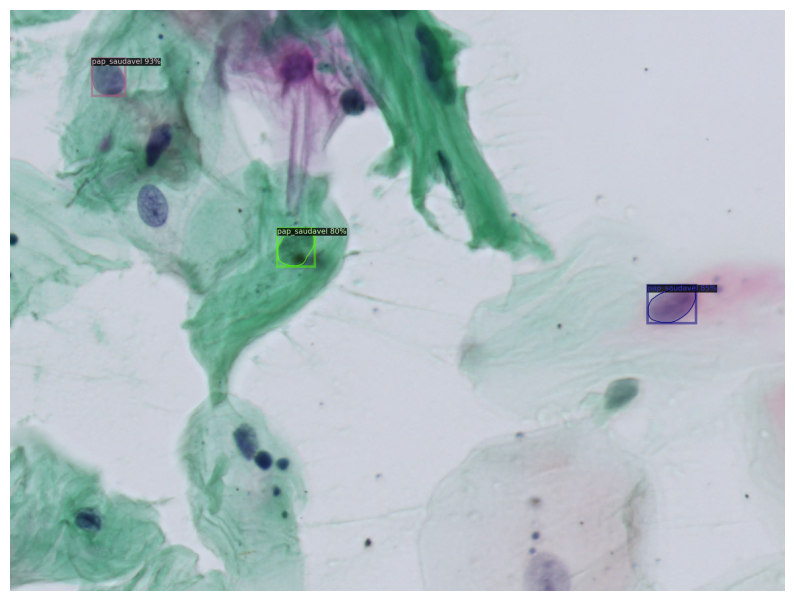

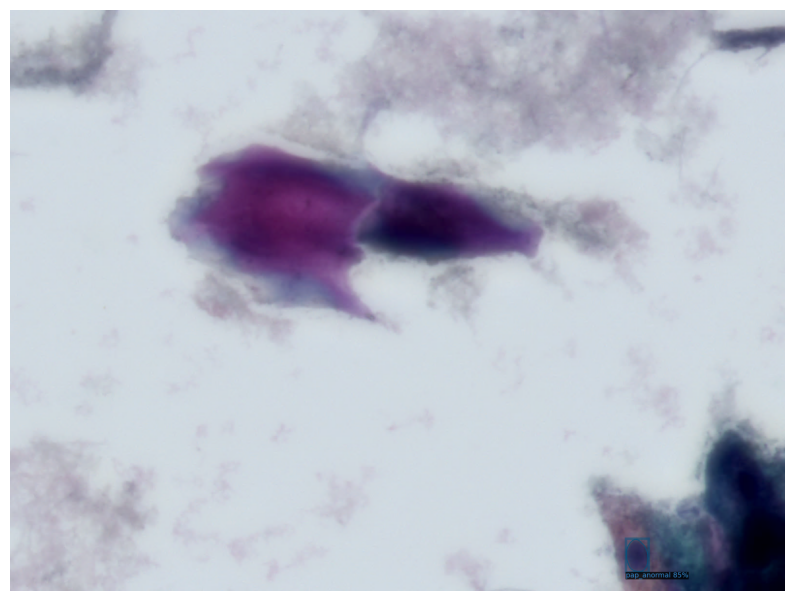

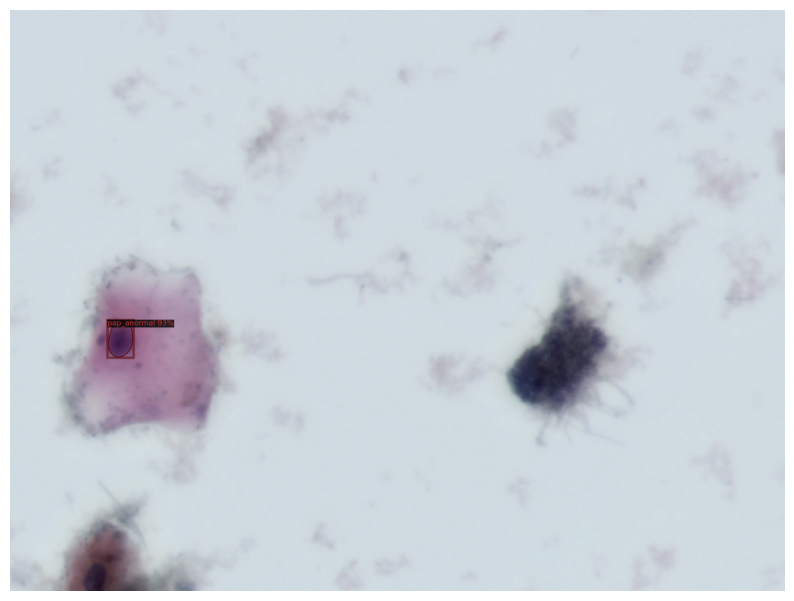

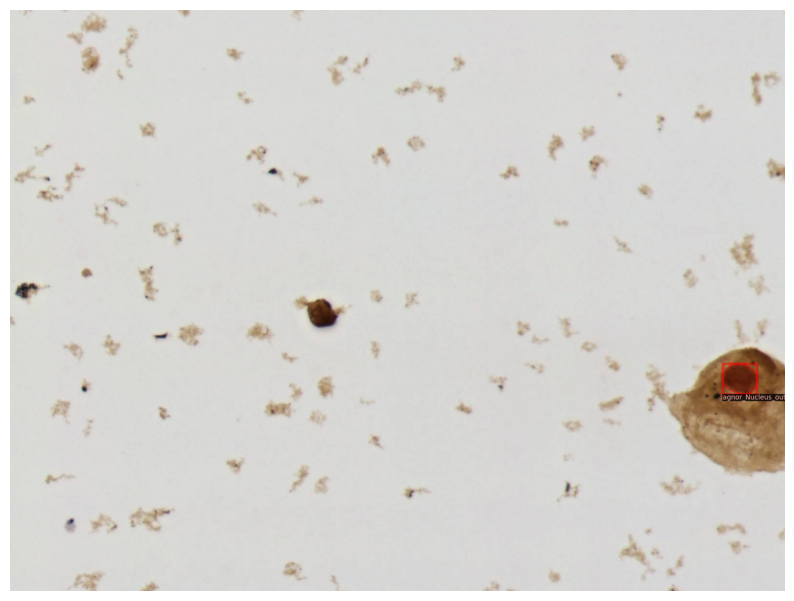

In [ ]:
config_path = os.path.join(OUTDIR, "mask_rcnn_R_50_FPN_1x.yaml")
weights_path = os.path.join(OUTDIR, "best.pth")
cfg_test = get_config(config_path, weights_path)

plot_test_results(
    cfg=cfg_test,
    DefaultPredictor=DefaultPredictor,
    dataset_name='unified_test',
    num_samples=4,
    threshold=0.75,
    alpha=0.1,
    plot_mask=True
)

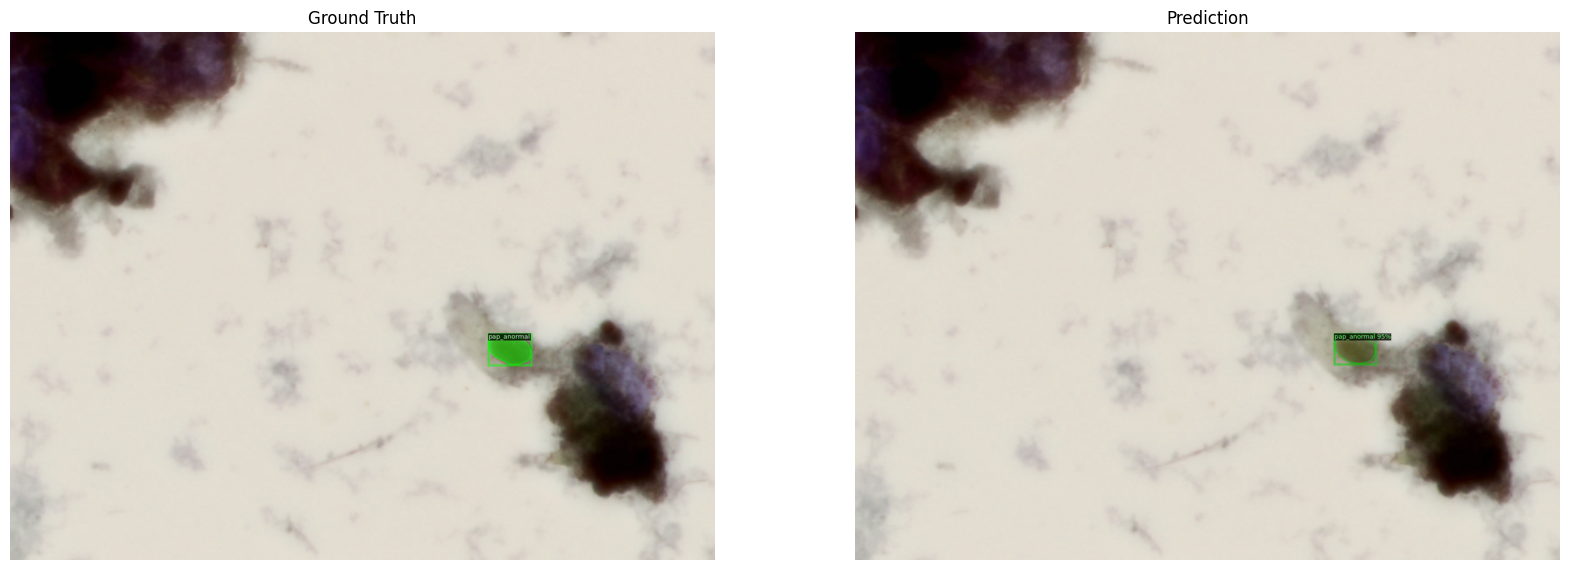

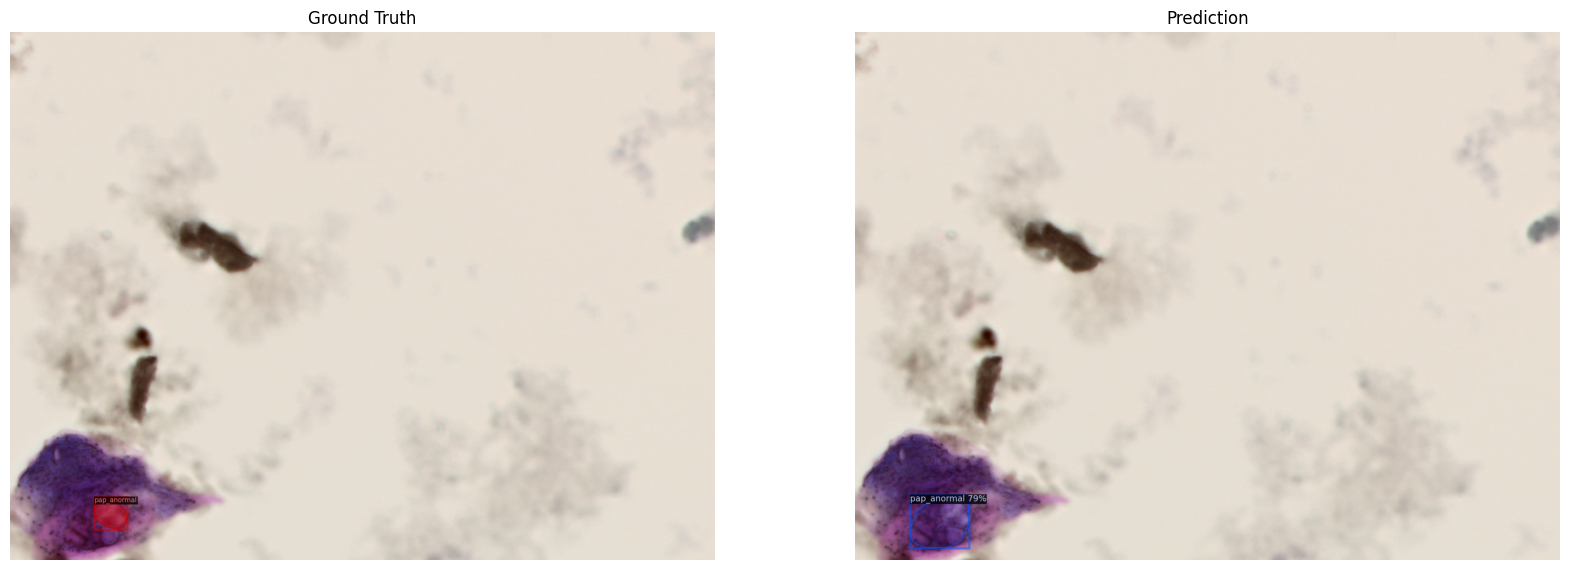

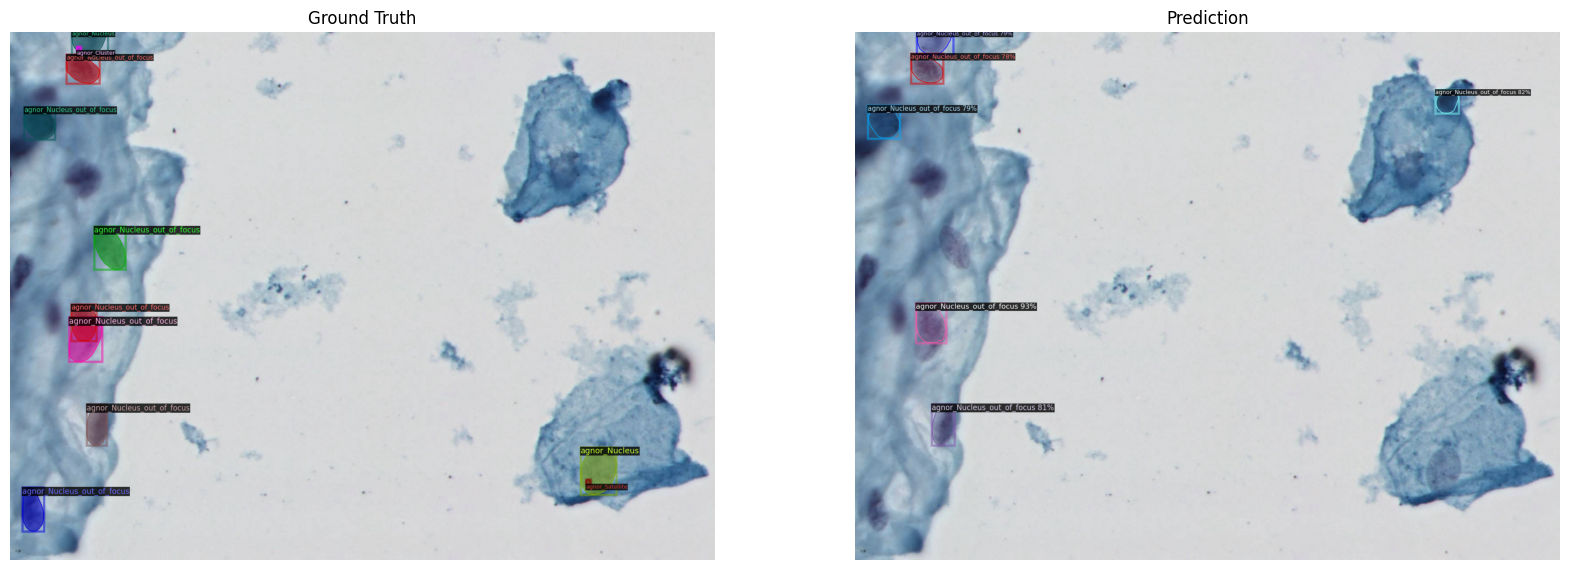

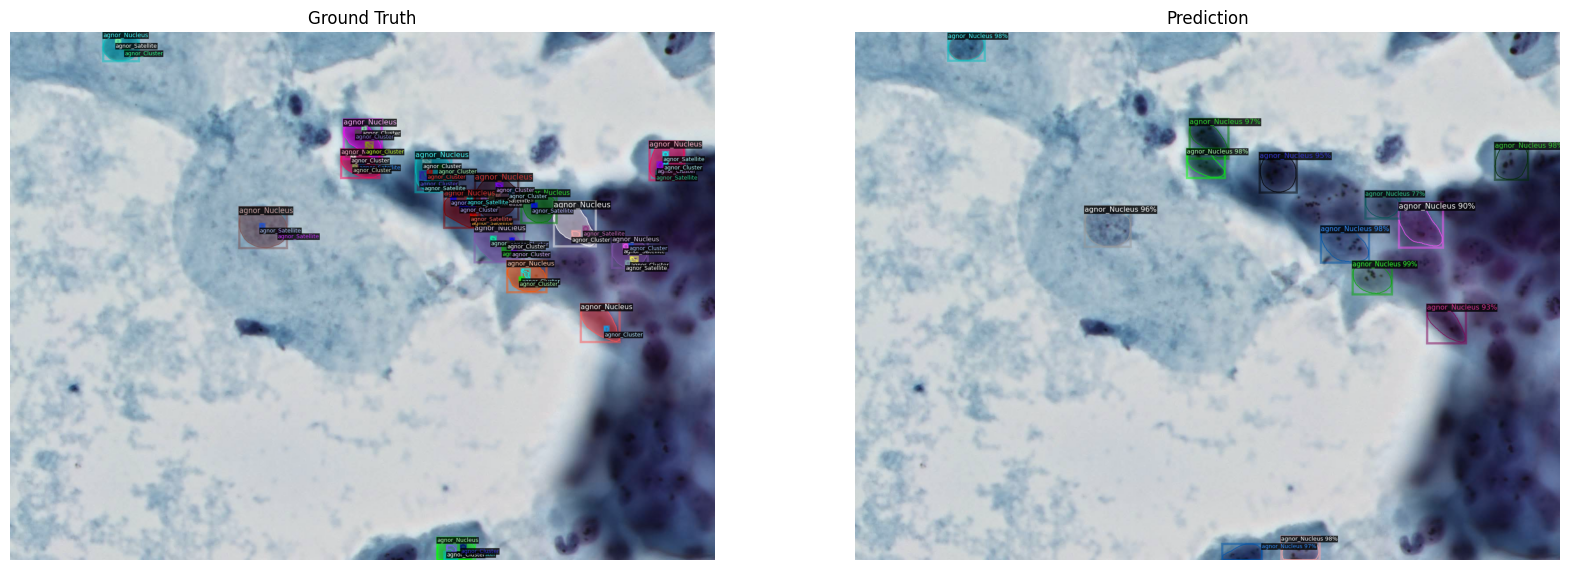

In [ ]:
import os
import random
import torch
import cv2
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer, random_color
import copy

def plot_test_results_with_gt(
    cfg,
    DefaultPredictor,
    dataset_name,
    num_samples=4,
    threshold=0.5,
    alpha=0.4,
    plot_mask=True
):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = copy.deepcopy(MetadataCatalog.get(dataset_name))
    num_classes = len(metadata.thing_classes)
    random.seed(42)
    colors = [random_color(rgb=True, maximum=1) for _ in range(num_classes)]
    colors = [tuple(int(c * 255) for c in color) for color in colors]
    if hasattr(metadata, "thing_colors"):
        delattr(metadata, "thing_colors")
    metadata.thing_colors = colors

    with torch.no_grad():
        predictor = DefaultPredictor(cfg)
        for det in random.sample(dataset_dicts, min(num_samples, len(dataset_dicts))):
            img = cv2.imread(det["file_name"])
            outputs = predictor(img)
            
            fig, axs = plt.subplots(1, 2, figsize=(20, 10))

            v_gt = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
            vis_gt = v_gt.draw_dataset_dict(det)
            axs[0].imshow(vis_gt.get_image()[:, :, ::-1])
            axs[0].axis('off')
            axs[0].set_title('Ground Truth')
            
            v_pred = UFSCVisualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
            instances = outputs['instances'].to("cpu")
            filtered_instances = instances[instances.scores > threshold] if hasattr(instances, "scores") else instances
            out = v_pred.draw_instance_predictions(
                filtered_instances,
                alpha=alpha,
                plot_mask=plot_mask
            )
            axs[1].imshow(out.get_image()[:, :, ::-1])
            axs[1].axis('off')
            axs[1].set_title('Prediction')
            
            plt.show()

config_path = os.path.join(OUTDIR, "mask_rcnn_R_50_FPN_1x.yaml")
weights_path = os.path.join(OUTDIR, "best.pth")
cfg_test = get_config(config_path, weights_path)

plot_test_results_with_gt(
    cfg=cfg_test,
    DefaultPredictor=DefaultPredictor,
    dataset_name='unified_test',
    num_samples=4,
    threshold=0.75,
    alpha=0.1,
    plot_mask=True
)
